Notebook 3: Conventional Machine Learning
=========================================

# Import Section

In [1]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement
from xgboost import XGBClassifier, plot_importance

import roafr_utils

In [2]:
%matplotlib inline
plt.style.use("dark_background");
plt.set_cmap('Dark2');
sns.set_palette('Dark2');

<Figure size 640x480 with 0 Axes>

In [3]:
df = roafr_utils.df_from_pickle('../data/df.p')

# Data Preprocessing for Machine Learning

In [4]:
df_ml = df.select_dtypes(include=np.number) \
          .drop(columns=['accident_id', 'accident_id_y']) \
          .dropna(axis=1, how='any')

In [5]:
df_ml = pd.get_dummies(data=df_ml, columns=['daylight', 'built-up_area', 'intersection_category', 
                                            'weather', 'collision_category', 'road_admin_category', 
                                            'traffic_regime', 'reserved_lane', 'plane_layout', 
                                            'surface_condition', 'infrastructure', 'location', 
                                            'is_weekend', 'role'])

In [6]:
features = df_ml.drop(columns='severity')
feature_columns = features.columns
target = df_ml['severity']
random_under_sampler = RandomUnderSampler()
features, target = random_under_sampler.fit_resample(X=features, y=target)

MAX_SAMPLE_SIZE = 10_000
sample_size = len(target)
if sample_size > MAX_SAMPLE_SIZE:
    sample_idx = sample_without_replacement(n_population=sample_size, 
                                            n_samples=MAX_SAMPLE_SIZE, 
                                            random_state=0)
    features = features.iloc[sample_idx]
    target = target.iloc[sample_idx]

In [7]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, )

# XGBoost

In [9]:
# Reconvert the features to DataFrames in order to keep the feature names
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
X_train.columns = feature_columns
X_test.columns = feature_columns

In [10]:
xgb_clf = XGBClassifier(n_jobs=multiprocessing.cpu_count()//2)

param_grid = {'max_depth': [2,4,6],
              'n_estimators': [100,200],
              'learning_rate': [0.05,0.1]}

grid = GridSearchCV(estimator=xgb_clf,
                    param_grid=param_grid,
                    cv=4,
                    n_jobs=2,
                    verbose=1)

grid.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 4, 6],
                         'n_estimators': [100, 200]},
             verbose=1)

In [11]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

In [12]:
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.54      0.71      0.61       671
           1       0.51      0.29      0.37       669
           2       0.63      0.70      0.66       660

    accuracy                           0.57      2000
   macro avg       0.56      0.57      0.55      2000
weighted avg       0.56      0.57      0.55      2000



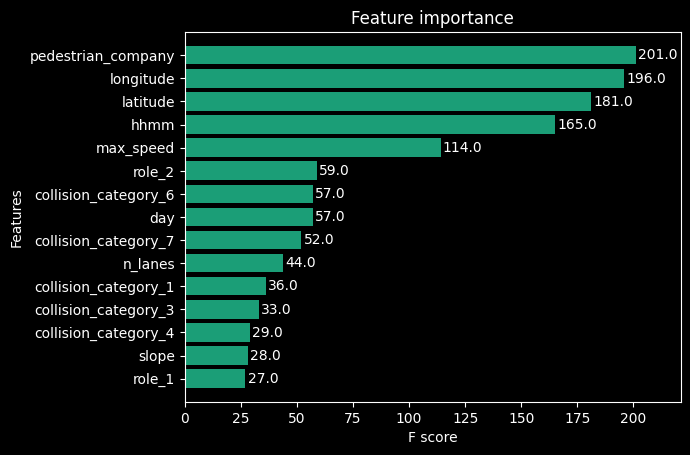

In [14]:
p = plot_importance(best_xgb, max_num_features=15, height=0.8, grid='off')
p.grid(False)

The feature importance plot enables us to identify the most important features used by XGBoost 
for the classification problem.
It seems like the location (represented by longitude and latitude) has the highest importance 
in this case. 

# Random Forest

In [15]:
random_forest_clf = RandomForestClassifier(n_estimators=100)
random_forest_clf.fit(X_train, y_train)
y_pred_rf = random_forest_clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_rf))

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       671
           1       0.44      0.31      0.36       669
           2       0.60      0.67      0.63       660

    accuracy                           0.54      2000
   macro avg       0.52      0.54      0.52      2000
weighted avg       0.52      0.54      0.52      2000



## Interpretation with Means of Permutation Importance
Random Forests can be interpreted with impurity-based feature importance, but this approach 
has some downsides.  
I will therefore use permutation feature importance to analyze the model. For this, I will 
calculate the feature importance weights for both the training and the test set and compare them. 
Those features that show a high # difference # between the calculated values for training and 
test set are considered to be causal for overfitting.

In [16]:
r_train = permutation_importance(random_forest_clf, 
                                 X_train, y_train,
                                 n_repeats=30,
                                 random_state=0)
r_test = permutation_importance(random_forest_clf, 
                                 X_test, y_test,
                                 n_repeats=30,
                                 random_state=0)                                 

In [19]:
importances_mean_df = pd.DataFrame(index=feature_columns)
importances_std_df = pd.DataFrame(index=feature_columns)

importances_mean_df['train'] = r_train.importances_mean
importances_mean_df['test'] = r_test.importances_mean

importances_std_df['train'] = r_train.importances_std
importances_std_df['test'] = r_test.importances_std

importances_mean_df['train_test_diff'] = abs(importances_mean_df['test'] - \
                                             importances_mean_df['train'])
importances_mean_df.sort_values(by='train_test_diff', ascending=False, inplace=True)
importances_mean_df.drop(columns=['train_test_diff'], inplace=True)
importances_std_df = importances_std_df.reindex_like(importances_mean_df)

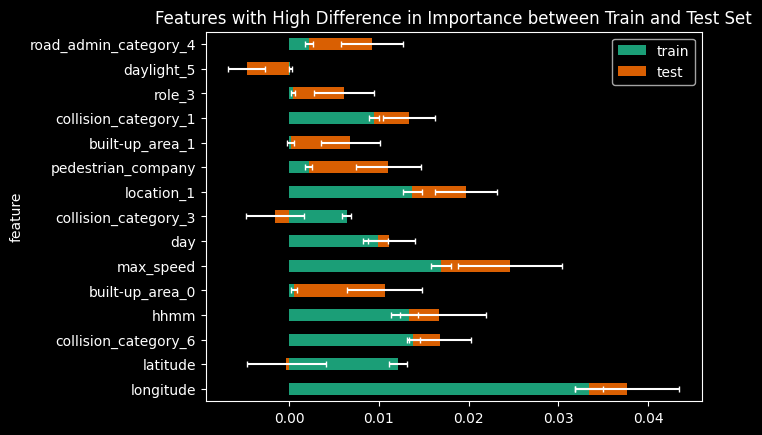

In [20]:
N_PLOT = 15
importances_mean_df[['train', 'test']].head(N_PLOT).plot(kind='barh',
                                                         capsize=2,
                                                         xerr=importances_std_df.head(N_PLOT), 
                                                         stacked=True);
plt.title('Features with High Difference in Importance between Train and Test Set');
plt.xlabel('');
plt.ylabel('feature');

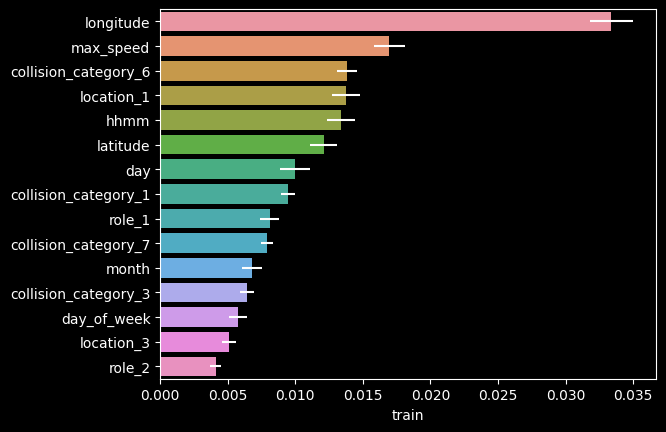

In [21]:
N_PLOT = 15
importances_mean_df.sort_values('train', ascending=False, inplace=True)
importances_std_df = importances_std_df.reindex_like(importances_mean_df)
sns.barplot(data=importances_mean_df.head(N_PLOT), 
            x='train', 
            y=importances_mean_df.head(N_PLOT).index.values,
            xerr=importances_std_df['train'].head(N_PLOT),
            capsize=1.0,
            ecolor='white');